# DeepMSim: A Deep Learning based MS/MS spectra Simulator
### *Muhammad Haseeb and Sumesh Kumar*
##### *CAP5610: Machine Learning - Fall 2019*
##### *School of Computing and Information Sciences*
##### *Florida International University (FIU)*

# Licence Information

This Transformer model construction for our project has been derived from the official <a href="https://tensorflow.org" class="external">Tensorflow</a> <a href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/transformer.ipynb" class="external">Transformer tutorial</a>.

### The MIT License

#### Copyright 2019 Muhammad Haseeb and Sumesh Kumar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software 
and associated documentation files (the "Software"), to deal in the Software without restriction, 
including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, 
and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, 
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial 
portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT 
LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. 
IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Licensed under the Apache License, Version 2.0 (the "License");

you may not use this file except in compliance with the License.
You may obtain a copy of the License [here](https://www.apache.org/licenses/LICENSE-2.0).
    
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Transformer model for MS/MS spectra simulation
We will implement a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to translate the peptide sequences into spectral peak sequences using TensorFlow.

Transformer model employs the concept of *self-attention* — the ability to attend to different positions of the input sequence to compute a representation of that sequence for modelling. It is composed of several layer multiconnected encoders and decoders that construct the output sequences. 

However, the drawback is that if the input sequences have a *temporal/spatial* (positional) relationships such as in peptide sequence data, a positional encoding such as <a href="https://arxiv.org/abs/1810.04805BERT" class="external">BERT encoding</a> must be added or the transformers will only see the input sequences as bag {set} of unordered and unrelated words. 

## Import the required libraries

In [1]:
# Required Imports
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf
import pandas as pd
import os
import re
import sys
import math
import time
import urllib
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import operator

# Data Acquisition
Let's get the annotated MS/MS spectral data libraries from <a href="https://chemdata.nist.gov/dokuwiki/doku.php?id=peptidew:cdownload" class="external">NIST.</a>

**CAUTION:** Make sure the downloaded spectral library datasets have been sourced from the same Mass-spectrometer instrument using the same fragmentation method.


In [2]:
# HYPERPARAMETER: Choose between HUMAN and MOUSE.
# species == HUMAN
# species == MOUSE

species = 'HUMAN'

assert (species == 'HUMAN' or species == 'MOUSE')

In [3]:
if species == 'HUMAN':
    human_url = 'ftp://chemdata.nist.gov/download/peptide_library/libraries/cptaclib/2015/cptac2_human_hcd_itraq_selected_part1.msp.tar.gz'
    human = 'cptac2_human_hcd_itraq_selected_part1.msp.tar.gz'
    msp_file = './speclib/cptac2_human_hcd_itraq_selected_part1.msp'

    data_dir = os.path.expanduser("./speclib")
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)

    if not os.path.exists('./speclib/cptac2_human_hcd_itraq_selected_part1.msp'):
        if not os.path.exists(human):
            !wget 'ftp://chemdata.nist.gov/download/peptide_library/libraries/cptaclib/2015/cptac2_human_hcd_itraq_selected_part1.msp.tar.gz'
    
        # Extract the tar ball into MSP file and move into the speclib folder
        !tar xvf 'cptac2_human_hcd_itraq_selected_part1.msp.tar.gz'
        os.rename('./cptac2_human_hcd_itraq_selected_part1.msp', msp_file)



In [4]:
# Getting the Mouse Orbitrap spectral library (.MSP format) from NIST and placing it in the speclib folder
if species == 'MOUSE':
    mouse_url = 'ftp://chemdata.nist.gov/download/peptide_library/libraries/cptaclib/2015/cptac2_mouse_hcd_selected.msp.tar.gz'
    mouse = 'cptac2_mouse_hcd_selected.msp.tar.gz'
    msp_file = './speclib/cptac2_mouse_hcd_selected.msp'

    data_dir = os.path.expanduser("./speclib")
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)

    if not os.path.exists('./speclib/cptac2_mouse_hcd_selected.msp'):
        if not os.path.exists(mouse):
            !wget 'ftp://chemdata.nist.gov/download/peptide_library/libraries/cptaclib/2015/cptac2_mouse_hcd_selected.msp.tar.gz'

        # Extract the tar ball into MSP file and move into the speclib folder
        #!tar xvf 'cptac2_mouse_hcd_selected.msp.tar.gz'
        tar = tarfile.open("cptac2_mouse_hcd_selected.msp.tar.gz")
        tar.extractall()
        tar.close()
        os.rename('./cptac2_mouse_hcd_selected.msp', msp_file)



# Data Extraction and Preprocessing

Mine the spectral libraries and extract corpuses for both languages. i.e. peptide sequences and their MS/MS spectra.
Construct a dataframe with sentences and their translations, with words separated by a '*space* and ending with ' .' for both languages. Then, Convert the dataframe to a tensor dataset.

## Process known Immonium Ions
The commonly observed immonium ions along with their isotopes are added to a dictionary un order to represent the ion sentences (from the corpus) in terms of the dictionary (bag of words)

In [5]:
# Known immonium ions
imm = np.array(['AA', 'RA', 'RB', 'RC', 'RD', 'RE', 'RF', 'RG', 'RJ', 'NA', 'NB', 'DA', 'DB', 'CA', 'EA', 'QA', 'QB',
                'QC', 'QD', 'GA', 'HA', 'HB', 'HC', 'HD', 'HE', 'HF', 'IA', 'IB', 'IC', 'LA', 'LB', 'LC', 'KA', 'KB',
                'KC', 'KD', 'KE', 'KF', 'MA', 'MB', 'FA', 'FB', 'PA', 'SA', 'TA', 'WA', 'WB', 'WC', 'WD', 'WE', 'WF',
                'WG', 'YA', 'YB', 'YC', 'VA', 'VB', 'VC', 'VD'])

# TODO: Add isotopes?
'''
# Make isotopes of an array of ions
iso = []

# For each immonium ion, append the +i and +2i isotopes
for im in imm:
    iso.append(im + '+i')
    iso.append(im + '+2i')

# Append the isotopes to the main dictionary
imm = np.append(imm, np.array(iso))
'''
# Make a set representation
simm= set(imm)

## Corpus Extraction
Extract the peptide sequence and ion sentence sequences from the dataset.

### MSP file parser

In [6]:
# Create empty lists to store temporary data
seq = []
X = []
Z = []
E = []

# Parse the MSP file and get the immonium ion dataset
def parseMSPfile(fname=None, dimm=None):
    header = False
    stnc = []
    with open(fname, 'r') as slib:
        for line in slib:
            # Check for empty line for spectrum end and header start
            if (line[0] == '\r' or line[0] == '#' or line[0] == '\n'):
                header = False
                X.append(stnc[:])
                stnc.clear()
                continue

            # Check if spectrum header
            if (header == False):
                if (line[:7] != 'Comment'):
                    key, val = line.split(':')

                    if key == 'Name':
                        # Take out the sequence
                        nm, chg = val.split('/')
                        seq.append(nm[1:])
                        # Take out the charge, nmods and eV (energy)
                        ch = chg.split('_')

                        # Append the charge
                        Z.append(int(ch[0]))
                        
                        # Append the energy
                        #print(ch)
                        E.append(float(ch[-1][:-3]))
                        

                    if key == 'Num peaks':
                        header = True

            # If not the header, then it is the peak list
            else:
                _, _, label = line.split('\t')

                # Clip off the first and last " "
                label = label[1:-1]

                # Extract label pattern
                lbls = re.findall(r"(?<!\/)(?<![A-Z])(I[A-Z][A-Z](?![A-Z]){2}[\/])", label)
                
                # FIXME: To also find isotopes
                #re.findall(r"(?<!\/)(?<![A-Z])(I[A-Z][A-Z](?![A-Z]){2}[+]*\d*i*)", label)
                
                lbls = list(map(lambda x: x[1:], lbls))
                
                lbls = list(map(lambda x: x[:-1], lbls))

                # If anything to append then append
                if lbls:
                    for lab in lbls:
                        if lab not in dimm:
                            dimm.add(lab[0])
                            #print ('Label Added:' + lab)
                    #print(lbls)
                    stnc.extend(lbls)

    # For the last one
    X.append(stnc[:])
    stnc.clear()

In [7]:
# Clear the lists
seq = []
X = []
Z = []
E = []

# Parse the MSP file and create a dataframe
_ = parseMSPfile(fname = msp_file, dimm = simm)

### Construct the two languages

In [8]:
# filter data based on the max charge
MAXZ = 3

In [9]:
# Construct a dataframe
dataset = pd.DataFrame(list(zip(seq, Z, E, X)), columns=['seq', 'z', 'E', 'ions'])

# Filter the dataset by the max charge 
dataset = dataset[dataset['z'] <= MAXZ]

# Print a few entries to visualize
print(dataset[:20])

                              seq  z     E              ions
0          AAAAAAAAAAAAAAAGAGAGAK  2  47.5          [KD, KF]
1          AAAAAAAAAAAAAAAGAGAGAK  2  66.0              [KF]
2          AAAAAAAAAAAAAAAGAGAGAK  3  30.0              [KF]
3          AAAAAAAAAAAAAAAGAGAGAK  3  33.0              [KF]
4          AAAAAAAAAAAAAAAGAGAGAK  3  37.0              [KF]
6                     AAAAAAAAAAR  2  26.0  [RG, RI, RA, RJ]
7   AAAAAAAAAGEAINPTYYDCHFAPEVGGR  3  60.0              [HA]
8                      AAAAAAAAAK  2  37.0              [KF]
9   AAAAAAAAAPAAAATAPTTAATTAATAAQ  2  63.4                []
10  AAAAAAAAAPAAAATAPTTAATTAATAAQ  3  39.9          [QA, QD]
12                   AAAAAAAAAVSR  2  28.9  [RG, RI, RA, RJ]
13                   AAAAAAAAAVSR  2  32.0          [RG, RJ]
14                   AAAAAAAAAVSR  2  40.0      [RG, RI, RJ]
15                   AAAAAAAAAVSR  3  18.2  [RG, RI, RA, RJ]
16      AAAAAAAAVPSAGPAGPAPTSAAGR  3  34.6              [RJ]
17                    AA

In [10]:
import operator
def preProcess(x,y):
    if y:
        n = len(y)
        indices = []
        result = []
        for i in range(n):
            indices.append(x.index(y[i][0]))
        tuples = list(zip(y,indices))
        tuples.sort(key=operator.itemgetter(1))
        result,second = zip(*tuples)
        result = " ".join(result) + ' -'
        return result
    else:
        return ' -'
        


lan1 = list(map(lambda x: " ".join(x), dataset['seq']))
lan2 = list(map(preProcess, dataset['seq'], dataset['ions']))

# Clear the duplicate data
seq.clear()
X.clear()
Z.clear()
E.clear()

In [12]:
# Insert the languages back to the dataframe
dataset['seq'] = lan1
dataset['ions'] = lan2

In [13]:
# Let's encode the charge and energy inside 
# the input peptide sequence sentence

# Convert z and E to strings
dataset['z'] = dataset['z'].astype(str)
dataset['E'] = dataset['E'].astype(str)

# TODO: Create a new column named enc with everything included in sentences
dataset['enc'] = dataset['z'] + ' ' + dataset['seq'] + ' ' + dataset['E'] + ' -' #+  dataset['E'] + ' -'  + ' ' +

# Language Encoding

Tokenize the sentences, construct tensors, embed the charge and eV information and do positional encoding (BERT).

In [14]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(dataset, test_size=0.2)


# Create a tf dataset object
train_examples = tf.data.Dataset.from_tensor_slices((train['enc'],train['ions']))
test_examples = tf.data.Dataset.from_tensor_slices((test['enc'],test['ions']))



### Sanity Checks

In [15]:
cnt = 0
for pep, ions in train_examples:
    print (pep)
    print (ions)
    cnt+=1
    if (cnt>=5):
        break
        
print(type(train_examples))

tf.Tensor(b'2 A A A A A A A A A A A A A A A G A G A G A K 47.5 -', shape=(), dtype=string)
tf.Tensor(b'KD KF -', shape=(), dtype=string)
tf.Tensor(b'2 A A A A A A A A A A A A A A A G A G A G A K 66.0 -', shape=(), dtype=string)
tf.Tensor(b'KF -', shape=(), dtype=string)
tf.Tensor(b'3 A A A A A A A A A A A A A A A G A G A G A K 30.0 -', shape=(), dtype=string)
tf.Tensor(b'KF -', shape=(), dtype=string)
tf.Tensor(b'3 A A A A A A A A A A A A A A A G A G A G A K 33.0 -', shape=(), dtype=string)
tf.Tensor(b'KF -', shape=(), dtype=string)
tf.Tensor(b'3 A A A A A A A A A A A A A A A G A G A G A K 37.0 -', shape=(), dtype=string)
tf.Tensor(b'KF -', shape=(), dtype=string)
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


## Tokenization

In [16]:
tokenizer_pep = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pep.numpy() for pep, ions in train_examples), target_vocab_size=2**10)

tokenizer_ion = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (ions.numpy() for pep, ions in train_examples), target_vocab_size=2**10)

### Sanity Check

In [17]:
sample_string = '3 P E P T I D E 64.3 -'

tokenized_string = tokenizer_pep.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_pep.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


tok = np.array([5,   4,   2,   1])
print(tokenizer_ion.decode(tok))

assert original_string == sample_string

for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_pep.decode([ts])))

Tokenized string is [17, 9, 1, 9, 11, 13, 6, 1, 72, 180, 185, 5]
The original string: 3 P E P T I D E 64.3 -
RG KFRJ -
17 ----> 3 
9 ----> P 
1 ----> E 
9 ----> P 
11 ----> T 
13 ----> I 
6 ----> D 
1 ----> E 
72 ----> 64
180 ----> .
185 ----> 3
5 ---->  -


In [18]:
# Hyperparameters
BUFFER_SIZE = 20000
BATCH_SIZE = 64

Add a start and end token to the input and target.

In [19]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pep.vocab_size] + tokenizer_pep.encode(
      lang1.numpy()) + [tokenizer_pep.vocab_size+1]

  lang2 = [tokenizer_ion.vocab_size] + tokenizer_ion.encode(
      lang2.numpy()) + [tokenizer_ion.vocab_size+1]
  
  return lang1, lang2

Operations inside `.map()` run in graph mode and receive a graph tensor that do not have a numpy attribute. The `tokenizer` expects a string or Unicode symbol to encode it into integers. Hence, you need to run the encoding inside a `tf.py_function`, which receives an eager tensor having a numpy attribute that contains the string value.

In [20]:
def tf_encode(pep, ions):
  return tf.py_function(encode, [pep, ions], [tf.int64, tf.int64])

In [21]:
train_dataset = train_examples.map(tf_encode)

# TODO: Do we need this filter?
#train_dataset = train_dataset.filter(filter_max_length)

# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


# We need an evaluation dataset
test_dataset = test_examples.map(tf_encode)
test_dataset = test_dataset.padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))

In [22]:
#pep_batch, ions_batch  = next(iter(val_dataset))
#pep_batch, ions_batch

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [23]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [24]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [25]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [26]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

# Scaled dot product attention

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `Q` and `K` should have a mean of 0 and variance of 1, and you get a gentler softmax.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [27]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

# Multi-head attention

Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

# Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [29]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Encoder and decoder

The transformer model follows the same general pattern as a standard sequence to sequence with attention model

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word. 

## Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [30]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

## Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [31]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

# Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [32]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

# Decoder

The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [33]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

# Transformer Construction

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [34]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

# Hyperparameter Setting

In [35]:
num_layers = 6
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pep.vocab_size + 2
target_vocab_size = tokenizer_ion.vocab_size + 2
dropout_rate = 0.1
MAX_LENGTH = 80

# Optimizer Settings
beta1 = 0.85
beta2 = 0.95
alpha = 1e-7

# Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [37]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=beta1, beta_2=beta2, 
                                     epsilon=alpha)

# Loss Function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [38]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [39]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [40]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='test_accuracy')

# Training

In [41]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [42]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `5` epochs.

In [43]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the next token that should be predicted.

For example, `peptide sequence` = "SOS  P E P T I D E 24.4 EOS"

`tar_inp` =  "SOS 2 P E P T I D E 24.4"

`tar_real` = "2 P E P T I D E 24.4 EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 
As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [44]:
EPOCHS = 1

In [45]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True,
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

### Test step

In [46]:
def test_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True,
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)
  
  test_loss(loss)
  test_accuracy(tar_real, predictions)

Peptide Sequence is used as the input language and Ion Sequence is the target language.

In [47]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> peps, tar -> ions
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.2567 Accuracy 0.0000
Epoch 1 Batch 50 Loss 2.9305 Accuracy 0.0198
Epoch 1 Batch 100 Loss 2.6645 Accuracy 0.0504
Epoch 1 Batch 150 Loss 2.4919 Accuracy 0.0608
Epoch 1 Batch 200 Loss 2.3467 Accuracy 0.0735
Epoch 1 Batch 250 Loss 2.1601 Accuracy 0.0963
Epoch 1 Batch 300 Loss 1.9784 Accuracy 0.1189
Epoch 1 Batch 350 Loss 1.8258 Accuracy 0.1388
Epoch 1 Batch 400 Loss 1.6956 Accuracy 0.1553
Epoch 1 Batch 450 Loss 1.5864 Accuracy 0.1698
Epoch 1 Batch 500 Loss 1.4898 Accuracy 0.1825
Epoch 1 Batch 550 Loss 1.4069 Accuracy 0.1944
Epoch 1 Batch 600 Loss 1.3328 Accuracy 0.2041
Epoch 1 Batch 650 Loss 1.2673 Accuracy 0.2127
Epoch 1 Batch 700 Loss 1.2107 Accuracy 0.2207
Epoch 1 Batch 750 Loss 1.1589 Accuracy 0.2273
Epoch 1 Batch 800 Loss 1.1150 Accuracy 0.2338
Epoch 1 Batch 850 Loss 1.0753 Accuracy 0.2394
Epoch 1 Batch 900 Loss 1.0389 Accuracy 0.2448
Epoch 1 Batch 950 Loss 1.0059 Accuracy 0.2498
Epoch 1 Batch 1000 Loss 0.9752 Accuracy 0.2535
Epoch 1 Batch 1050 Loss 0.9469 Accur

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-5cebe393e521>", line 9, in <module>
    train_step(inp, tar)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/eager/def_function.py", line 457, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/eager/def_function.py", line 487, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/eager/function.py", line 1823, in __call__
    return graph_function._filtered_call(args, kwargs)  # pylint: disable=protected-access
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/eager/function.py", line 1141, in _filtered_call
    self.captured_inputs)
  File "/usr/local/lib/py

KeyboardInterrupt: 

# Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the peptide sequence tokenizer (`tokenizer_pep`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_ion.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the `argmax` of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

In [48]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pep.vocab_size]
  end_token = [tokenizer_pep.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pep.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is Ions, the first word to the transformer should be the
  # ions start token.
  decoder_input = [tokenizer_ion.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_ion.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [49]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_pep.encode(sentence)

  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_pep.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_ion.decode([i]) for i in result 
                        if i < tokenizer_ion.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [50]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_ion.decode([i for i in result 
                                            if i < tokenizer_ion.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

### Testing stage

Here we test are trained transformer model on unseen data.

In [51]:
test_loss.reset_states()
test_accuracy.reset_states()

  # inp -> peps, tar -> ions
for(batch, (inp, tar)) in enumerate(test_dataset):
    test_step(inp, tar)
print ('Loss {:.4f} Accuracy {:.4f}'.format( test_loss.result(), 
                                                test_accuracy.result()))

Loss 0.3292 Accuracy 0.3666


# Translate Peptide Sequences

Input: 2 A A A D D G E E P K 22.4 -
Predicted translation: EA KF -


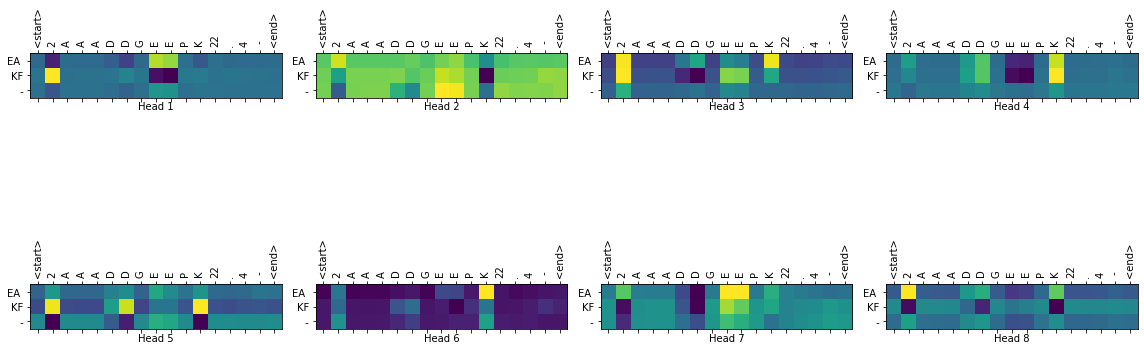

Real Translation: EA KD KF -


In [60]:
translate("2 A A A D D G E E P K 22.4 -", plot='decoder_layer6_block2')
print('Real Translation: EA KD KF -')

Input: 2 T A G W N I P M G M L Y N R 47.4 -
Predicted translation: WD WE WA WF YA MA RG RI RJ -


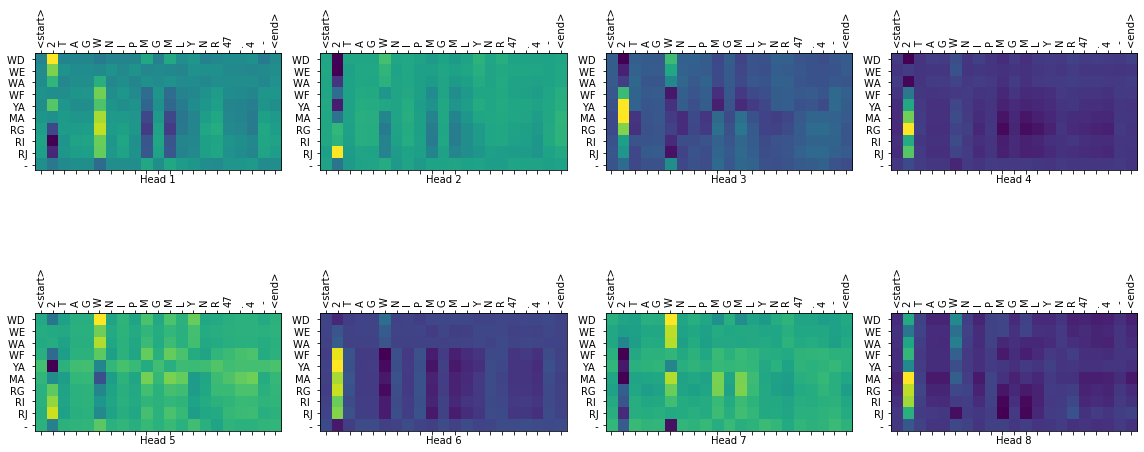

Real Translation: 


In [57]:
translate('2 T A G W N I P M G M L Y N R 47.4 -', plot='decoder_layer6_block2')
print ('Real Translation: ')

In [ ]:
translate('3 P E P T I D E K 52.8 -', plot='')
print ('Real Translation: ')

# Summary

In this notebook, we convert the peptide sequence to ion sequence generation problem to portuguese to english translation problem. The obtained accuracy is about 30%.